# Inferring QoE Metrics for Real-time Applications

In [107]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Notebook link: [https://github.com/SNL-UCSB/cs176c-discussion-section/tree/master/spring24/week7](https://github.com/SNL-UCSB/cs176c-discussion-section/tree/master/spring24/week7)

# Download pcap at: [https://drive.google.com/file/d/1iqNtH8ip3PBdozZ3ODHvZK6851eBcHlv/view?usp=sharing](https://drive.google.com/file/d/1iqNtH8ip3PBdozZ3ODHvZK6851eBcHlv/view?usp=sharing)

# Download csv at: [https://drive.google.com/file/d/1F7jOnwPn7mLDgyoFdGhEBqomFiihFlKF/view?usp=sharing](https://drive.google.com/file/d/1F7jOnwPn7mLDgyoFdGhEBqomFiihFlKF/view?usp=sharing)

# Download parquet (.zip) at: [https://drive.google.com/file/d/1J5_85CYTN8b5UZ4EtH1BQVsiAc_Ov2Sq/view?usp=sharing](https://drive.google.com/file/d/1J5_85CYTN8b5UZ4EtH1BQVsiAc_Ov2Sq/view?usp=sharing)

### Review

Real-time applications use the RTP protocol over UDP to send traffic for audio and video streams between participants.  

Real-time applications use two different models:

### P2P model

#### Peer-to-peer connections send data directly between peers (as the name suggests). Often peers may be behind a NAT and require the STUN protocol to setup entries in NAT and accept traffic from other peers. 

### P2P Setup 
#### Finding a peer

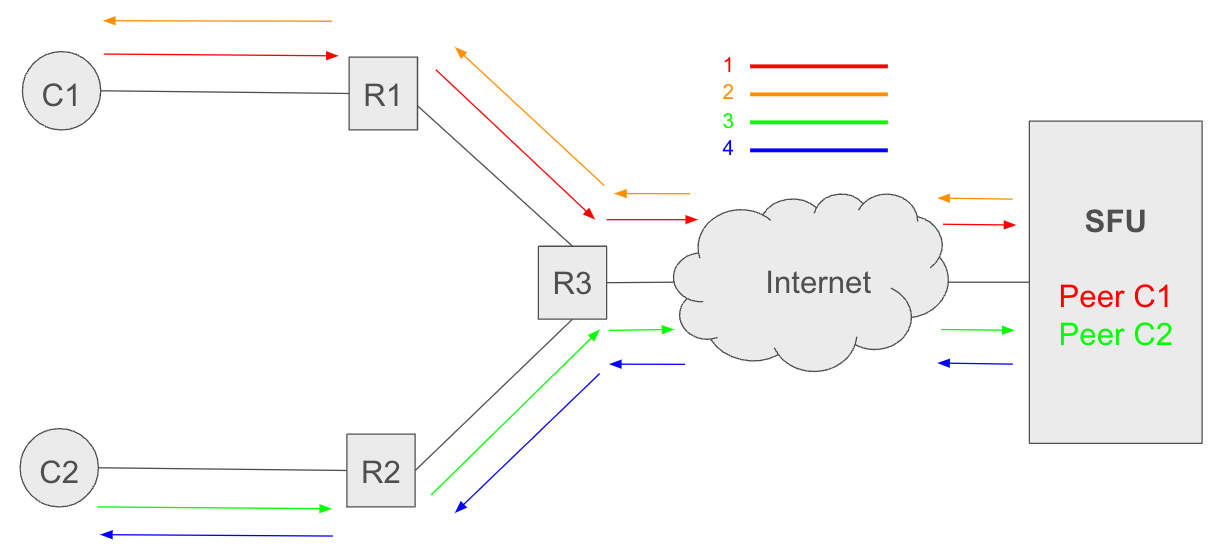

### P2P Setup 

#### STUN request / response

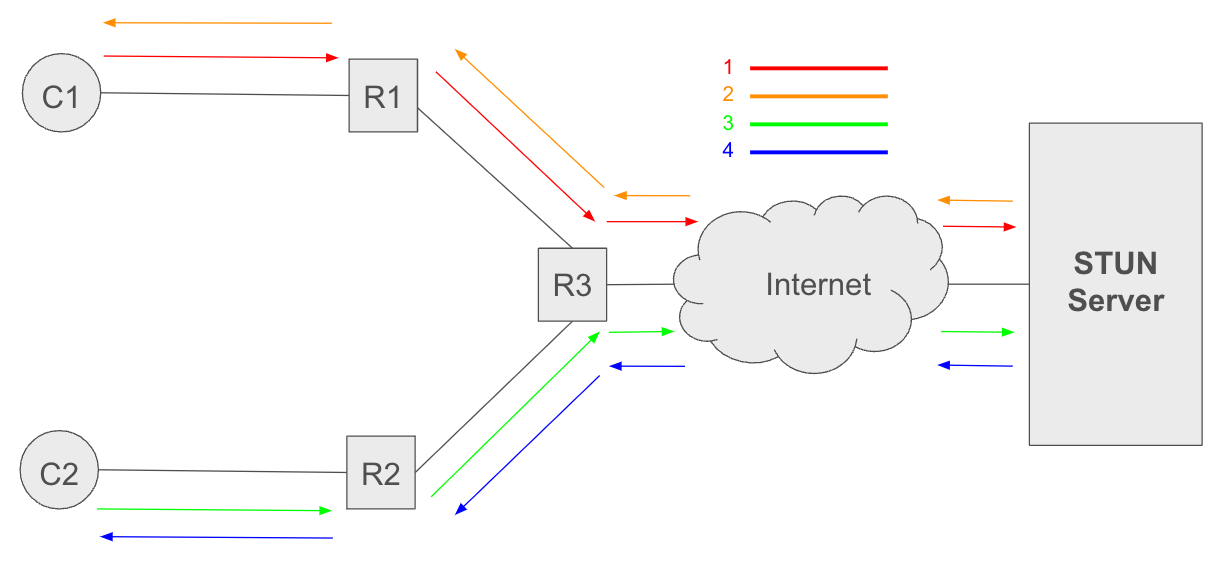

### P2P Connection


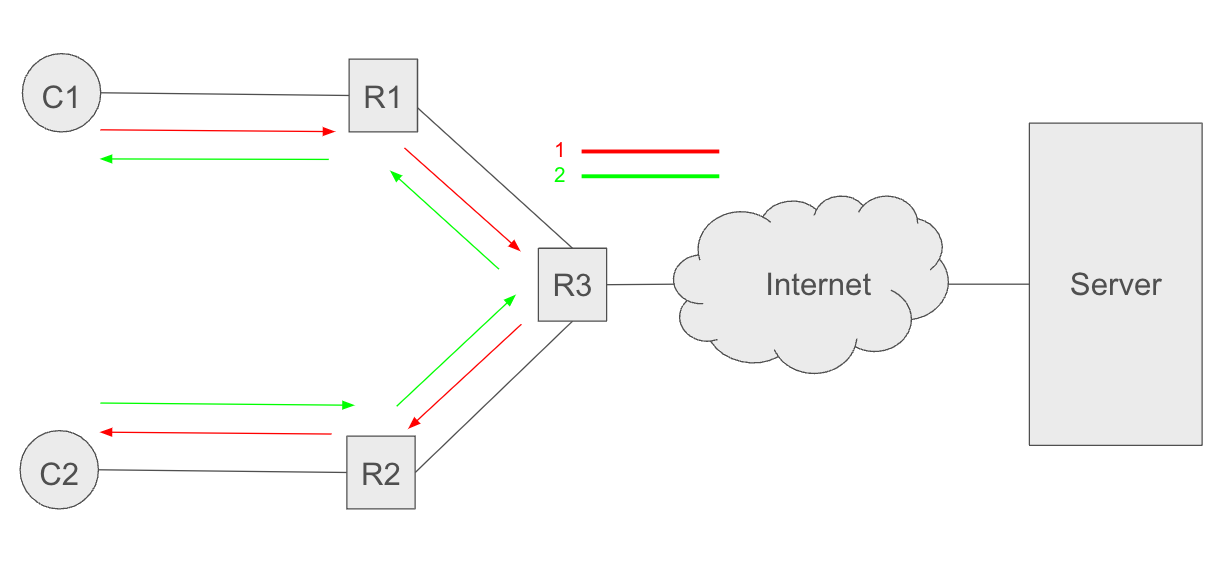

### P2P model doesn't scale well


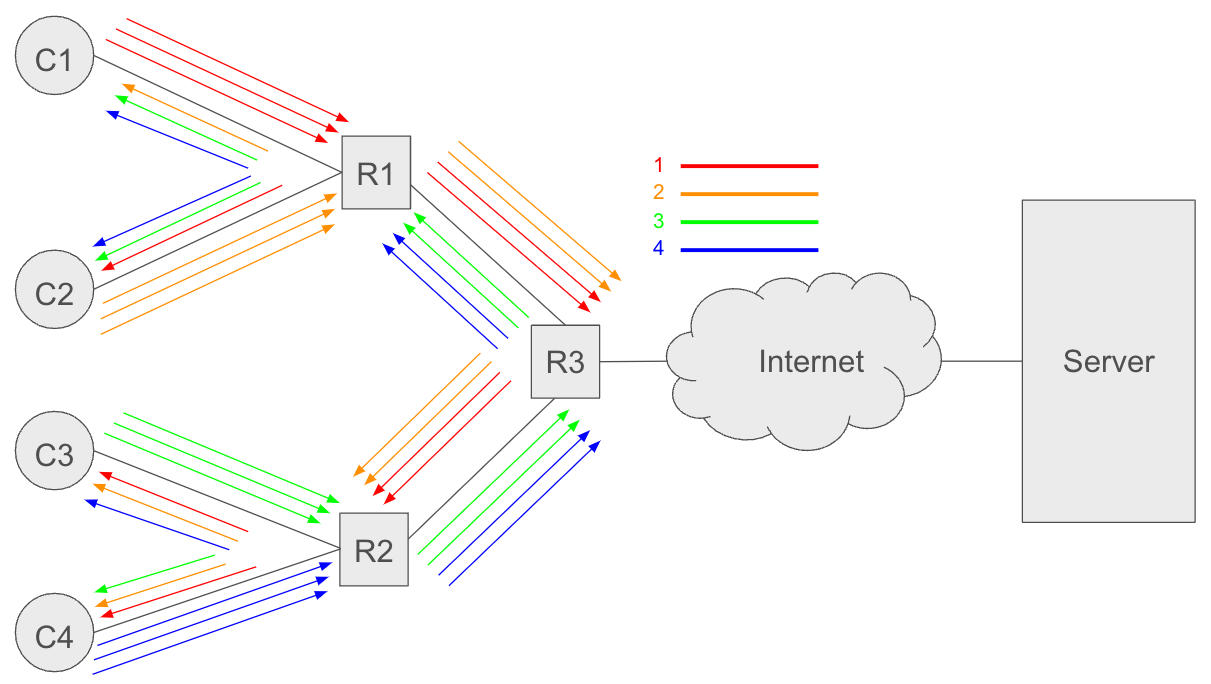

### SFU model

#### Selective Forwarding Unit used by major providers, and can be more efficient in conference calls between more than 2 users. This is often why services will offer free connections between two users but charge a premium for more than 2 users. 

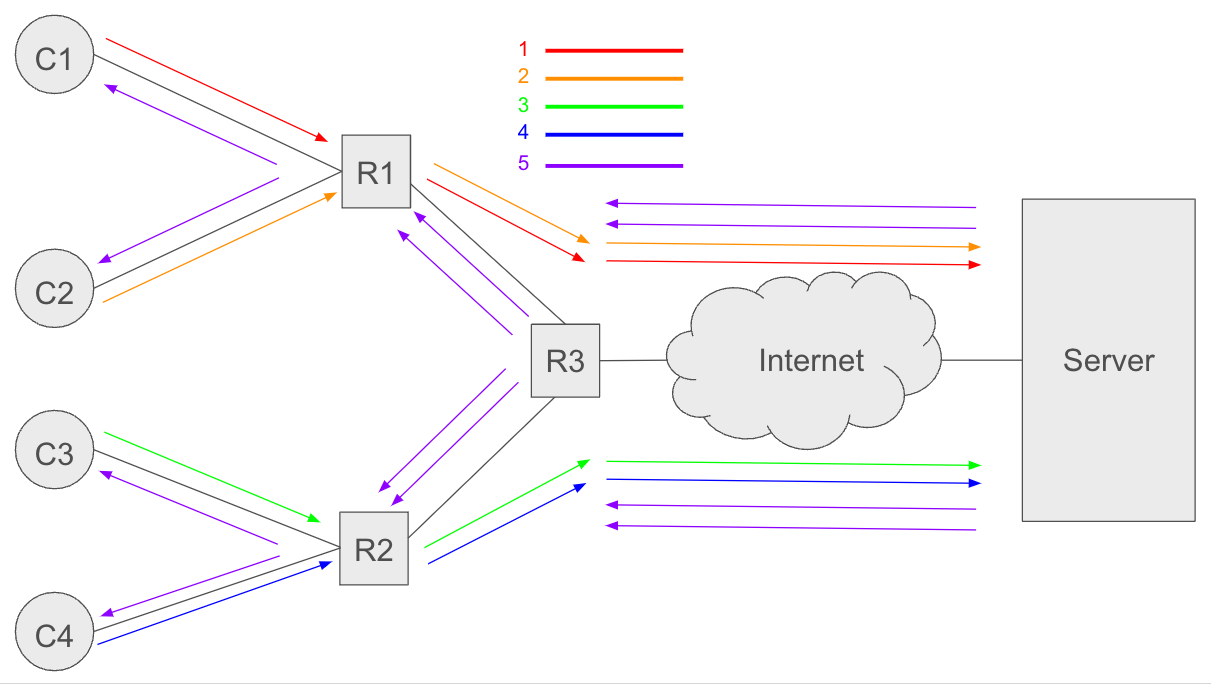

## Load up the PCAP in wireshark

### In this packet capture we have a video conferencing call going on with one or more participants.  
#### 1. What are the relevant IP addresses for this call?
#### 2. Is this conference call more likely using an SFU model or P2P model?
#### 3. What service / application is likely be used for this video conference call?

In [ ]:
%load ./review1-answers.txt

### You can decode a specific flow as RTP based on the port number in the UDP connection. However we are going to extract the header fields into a CSV

```tshark -r <pcap_name> -d udp.port==<PORT1>,rtp -d udp.port==<PORT2>,rtp -T fields -E separator=/t -e <field_name_1> -e <field_name_2> ... -e <field_name_k>```

###  RTP Packet Structure
```
 0                   1                   2                   3
 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|V=2|P|X|  CC   |M|     PT      |       Sequence Number         |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                           Timestamp                           |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|           Synchronization Source (SSRC) Identifier            |
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
|            Contributing Source (CSRC) Identifiers             |
|                             ....                              |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
```

### Header fields we care about

**frame.time_epoch** (Packet arrival timestamp)  
**rtp.seq** (RTP sequence number)  
**rtp.timestamp** (RTP frame timestamp)  
**rtp.ssrc** (RTP ssrc id)  

### Bash script to extract RTP headers from pcap to csv for this PCAP

```
#!/bin/bash

if [ "$#" -ne 2 ]; then
    echo "Usage: $0 <pcap_name> <output_csv>"
    exit 1
fi

PCAP_FILENAME=$1
CSV_FILENAME=$2

# Create a header row for the CSV
echo "pkt_timestamp,src_ip,src_port,dst_ip,dst_port,udp_len,rtp_seq_num,rtp_timestamp,rtp_ssrc_id" > $CSV_FILENAME

# Extract header fields from PCAP from UDP flows with either port 63346 or 36513
tshark -r $PCAP_FILENAME -d udp.port==63346,rtp -d udp.port==36513,rtp -T fields -E separator=, -e frame.time_epoch -e ip.src -e udp.srcport -e ip.dst -e udp.dstport -e udp.length -e rtp.seq -e rtp.timestamp -e rtp.ssrc >> $CSV_FILENAME

```


## Initialize Spark (or use Pandas)

In [20]:
from pyspark.sql import SparkSession, HiveContext, DataFrame, Window
from pyspark .sql.types import StructType, StringType, IntegerType, ShortType, DoubleType, LongType, TimestampType, ArrayType, StructField, FloatType, BooleanType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import col

In [4]:
spark = SparkSession \
        .builder \
        .appName("Local VCA Analysis") \
        .config("spark.driver.memory","2G") \
        .config("spark.executor.memory","2G") \
        .config("spark.executor.instances", "1") \
        .getOrCreate()

24/05/24 07:45:52 WARN Utils: Your hostname, snl-server-5 resolves to a loopback address: 127.0.1.1; using 128.111.5.231 instead (on interface eno1)
24/05/24 07:45:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 07:45:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [106]:
!pyspark --version

24/05/24 15:59:06 WARN Utils: Your hostname, snl-server-5 resolves to a loopback address: 127.0.1.1; using 128.111.5.231 instead (on interface eno1)
24/05/24 15:59:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.22
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.


## Read the CSV with Spark (or Pandas)

In [5]:
csv_file = '<insert path to CSV file here>'

## Create Parquet with Spark (optional)

In [8]:
parquet_file = '<insert path to parquet file here>'

In [12]:
df = spark.read.option("header",True).options(inferSchema=True).options(delimiter=',').csv(csv_file)

In [ ]:
df.write.parquet(parquet_file)

## Check Schema

#### It's important to check the schema of the dataframe you are working with when you use the inferSchema option. Otherwise you can set the schema manually.

In [49]:
df = spark.read.parquet(parquet_file)

In [50]:
df.printSchema()

root
 |-- pkt_timestamp: double (nullable = true)
 |-- src_ip: string (nullable = true)
 |-- src_port: string (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- dst_port: string (nullable = true)
 |-- udp_len: string (nullable = true)
 |-- rtp_seq_num: integer (nullable = true)
 |-- rtp_timestamp: long (nullable = true)
 |-- rtp_ssrc_id: string (nullable = true)



#### Both the port numbers and the udp packet length are all treated as strings when we would like them as ints, specifically a LongType.

In [51]:
df = df.withColumn('src_port', col('src_port').cast(LongType()))
df = df.withColumn('dst_port', col('dst_port').cast(LongType()))
df = df.withColumn('udp_len', col('udp_len').cast(LongType()))

#### Should have a schema matching something like this
```
root
 |-- pkt_timestamp: double (nullable = true)
 |-- src_ip: string (nullable = true)
 |-- src_port: long (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- dst_port: long (nullable = true)
 |-- udp_len: long (nullable = true)
 |-- rtp_seq_num: integer (nullable = true)
 |-- rtp_timestamp: long (nullable = true)
 |-- rtp_ssrc_id: string (nullable = true)
 ```

#### Filter packets between the two participants in the conference call, make sure to filter on both the IP address and port of all participants.

In [52]:
flow_df = df.filter(((col('src_ip') == '192.168.0.203') & \
                     (col('src_port') == 63346) & \
                     (col('dst_ip') == '107.223.12.141') & \
                     (col('dst_port') == 36513)) | \
                    ((col('src_ip') == '107.223.12.141') & \
                     (col('src_port') == 36513) & \
                     (col('dst_ip') == '192.168.0.203') & \
                     (col('dst_port') == 63346)))

#### If we decode the UDP packets as RTP, we observe that there are other packets multiplexed over the same flow, such as RTCP or STUN.   
#### These packets are not RTP protocol and are not used for the methods we are using to infer QoE
#### If a packet is not RTP then wireshark will fail to extract RTP headers from this packet and we will observe NULL values in our dataframe
#### Filter out all packets with a NULL value for the RTP sequence number, RTP timestamp, or RTP ssrc ID

In [54]:
rtp_df = flow_df.filter(col('rtp_seq_num').isNotNull() & \
                        col('rtp_timestamp').isNotNull() & \
                        col('rtp_ssrc_id').isNotNull())

## Identifying Streams

#### We can identify RTP streams based on a combination of (Source IP, Source Port, Destination IP, Destination Port, SSRC id)

#### 4. Why does each RTP stream need to have its own unique SSRC id?   

#### 5. How many different RTP streams are present in this packet capture? How many in each direction?

#### 6. Can you identify the media type for each RTP stream? How bulletproof is the methodology?

In [ ]:
%load ./review2-code.txt

In [ ]:
%load ./review2-answers.txt

## Audio / Video Frames

Real-time content groups data into frames that are re-assembled at the end user and rendered.  
Each frame will represent a very short amount of time (less than a second), however in video streaming we grouped data into chunks representing multiple seconds of video.  
To group packets into frames we will utilize the RTP timestamp in the RTP headers.  
From Section 5.1 in [RFC 3550](https://datatracker.ietf.org/doc/html/rfc3550#section-5.1) we know that **several consecutive RTP packets will have equal timestamps if they are (logically) generated at once, e.g., belong to the same video frame.**

#### 7. How many frames are sent by each RTP stream?

In [ ]:
%load ./review3-code.txt

In [ ]:
%load ./review3-answers.txt

## Inferring Frame Size

#### The size of the frames in each stream can be used to infer whether the media type is audio or video.

#### 8. Plot a time series of all audio RTP stream frame sizes for each frame.

#### 9. Plot a time series of all video RTP stream frame sizes for each frame.

In [ ]:
frame_fields = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'rtp_ssrc_id', 'rtp_timestamp']

frames_df = rtp_df.groupBy(*frame_fields)\
                     .agg(F.min('pkt_timestamp').alias('frame_start_time'),
                          F.max('pkt_timestamp').alias('frame_end_time'),
                          F.count('*').alias('frame_pkt_count'),
                          F.sum(col('udp_len')).alias('frame_size'))
                     
frame_window = Window.partitionBy(*ssrc_flow_fields).orderBy('rtp_timestamp')
frames_df = frames_df.withColumn('frame_num', F.row_number().over(frame_window))

frames_pd = frames_df.select('frame_num', 'frame_size', 'rtp_ssrc_id')\
                      .sort('frame_num')\
                      .toPandas()

In [ ]:
audio_ssrc_ids = ['0x06ec3145', '0xd92d7a3b']
video_ssrc_ids = ['0x55934d58', '0x989254a4']

audio_frames_df = frames_df.filter(col('rtp_ssrc_id').isin(audio_ssrc_ids))
video_frames_df = frames_df.filter(col('rtp_ssrc_id').isin(video_ssrc_ids))

In [ ]:
audio_pd = audio_frames_df.select('frame_end_time', 'frame_size', 'rtp_ssrc_id')\
                          .sort('frame_end_time')\
                          .toPandas()
video_pd = video_frames_df.select('frame_end_time', 'frame_size', 'rtp_ssrc_id')\
                          .sort('frame_end_time')\
                          .toPandas()

In [ ]:
%load ./graph-frame-sizes-code.txt

In [ ]:
%load ./graph-audio-frame-sizes-code.txt

In [ ]:
%load ./graph-video-frame-sizes-code.txt

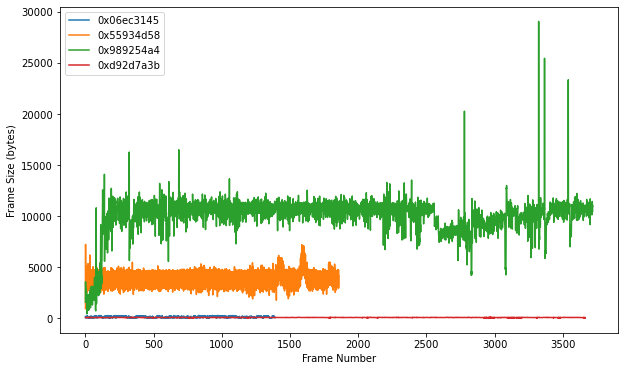

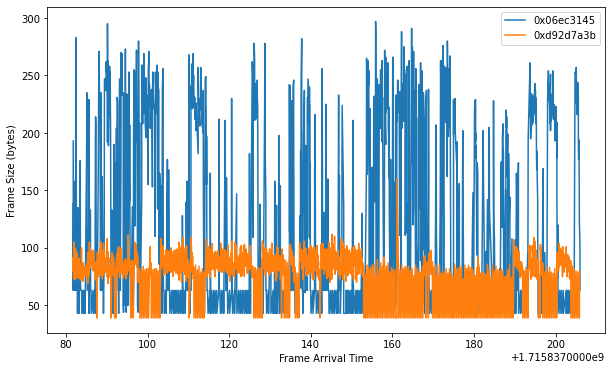

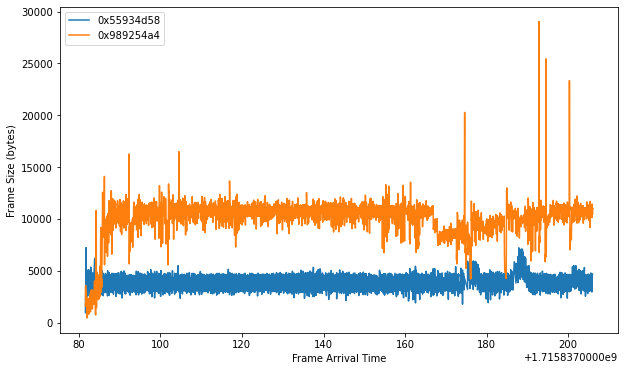

## Inferring FPS

#### Each RTP stream will try to maintain a certain fps which will determine the smoothness of the video content.  
#### We can infer the FPS of the stream after the delivery of each frame, by counting the number of frames that finished delivering in the past second, further described in this [paper](https://dl.acm.org/doi/abs/10.1145/3517745.3561414). 

#### 10. Plot a time series of the FPS after the delivery of each frame for all video RTP streams.
Hint: If you are using pyspark the [Window.rangeBetween()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Window.rangeBetween.html) function is very useful for this calculation

In [ ]:
%load ./graph-fps-code.txt

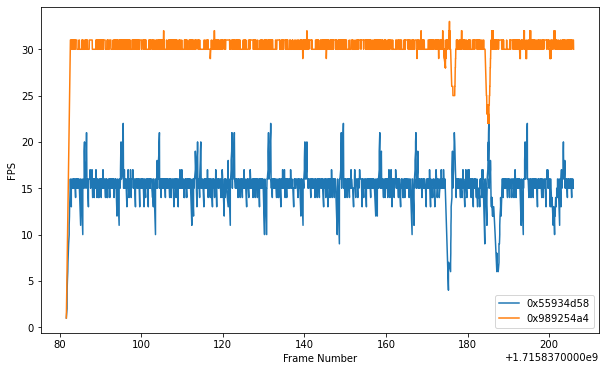

## Infer Video Sampling Rate

#### Sampling rate (in Hz) is the rate at which the timestamp increases over 1 second of wallclock time.
#### For example, if video is being streamed at 90kHz then we would see the RTP timestamp increase by 90k between two frames that should be played exactly 1 second apart.  
#### Using this fact, we can infer the sampling rate that is likely used by the RTP stream. Most common sampling rates are 8kHz, 16kHz, 48kHz, 90kHz.  
#### Look at the RTP timestamp difference between the last frame and first frame in each 1 second window that we used in the fps calculation (Window.rangeBetween())  

#### 11. What are the sampling rates used by the audio RTP streams in this capture?  
#### 12. What are the sampling rates used by the video RTP streams in this capture?  

In [ ]:
%load ./review5-answers.txt

In [ ]:
%load ./review5-audio-code.txt

In [ ]:
%load ./review5-video-code.txt

## Calculating Frame-level Jitter 

#### Using the sampling rates, we can infer the jitter for each RTP stream, which is measuring the variance in the delivery of frames. 
#### The applications will maintain a jitter buffer based on the current estimate of jitter to avoid stuttering / freeze frames.
#### The calculation for jitter can be taken from the Appendix A.8 of [RFC 3550](https://datatracker.ietf.org/doc/html/rfc3550#appendix-A.8)

```
The inputs are r->ts, the timestamp from
the incoming packet, and arrival, the current time in the same units.
Here s points to state for the source; s->transit holds the relative
transit time for the previous packet, and s->jitter holds the
estimated jitter.  The jitter field of the reception report is
measured in timestamp units and expressed as an unsigned integer, but
the jitter estimate is kept in a floating point.  As each data packet
arrives, the jitter estimate is updated:

  int transit = arrival - r->ts;
  int d = transit - s->transit;
  s->transit = transit;
  if (d < 0) d = -d;
  s->jitter += (1./16.) * ((double)d - s->jitter);

```
Both `s->transit` and `s->jitter` can be initialized to 0.

#### 13. Plot the frame-level jitter for audio packets

#### 14. Plot the frame-level jitter for video packets

For pyspark, you will need to define an RDD function that iteratively computes an estimate, since the jitter estimate after the arrival of a frame is dependent on the arrivals of all the frames before it.

In [ ]:
%load ./graph-audio-jitter-code.txt

In [ ]:
%load ./graph-video-jitter-code.txt

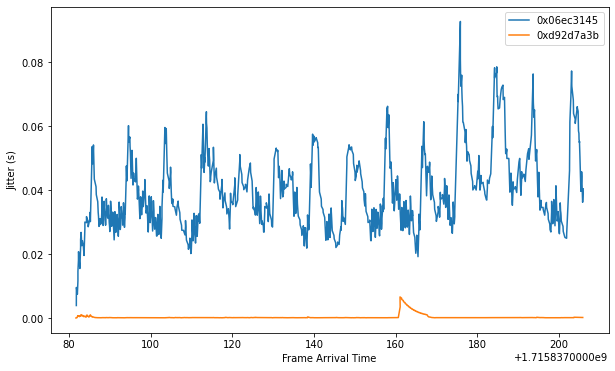

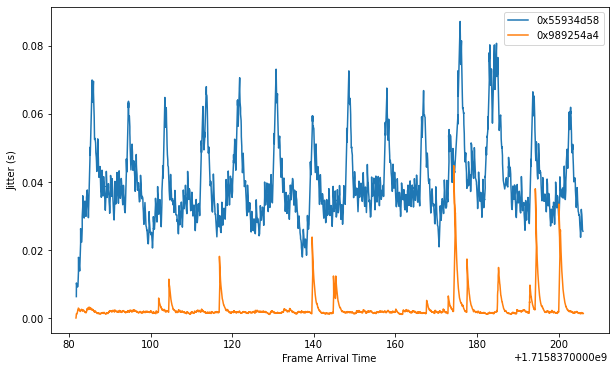